# コラム：量子リザーバコンピューティング

リカレントニューラルネットワーク(Recurrent neural network, RNN)とは主として時系列データの学習に用いられるニューラルネットワークモデルの一種である。このコラムではRNNの一種であるリザーバコンピューティング(Reservoir computing)と、その量子版である量子リザーバコンピューティング(Quantum reservoir computing)について解説する。

必要なライブラリの動作を確認しているバージョンは下記のとおりである。

In [1]:
import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
import time

print("python: %s"%sys.version)
print("numpy: %s"%np.version.version)
print("scipy: %s"%scipy.version.version)
print("matplotlib: %s"%matplotlib.__version__)
print("tensorflow: %s"%tf.VERSION)
print("tqdm: %s"%tqdm._version.__version__)


python: 3.5.5 |Anaconda 4.2.0 (64-bit)| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]
numpy: 1.14.3
scipy: 1.2.0
matplotlib: 2.1.2
tensorflow: 1.3.0
tqdm: 4.31.1


## 問題設定
時系列データとは入力の系列に時間的な相関が存在するようなデータである。例えば株価の推移、電気信号の入出力、文章における言葉の系列、音声信号などが時系列である。こうしたデータに対し、株価の予測、応答の解析、続く文章の予測、音声信号からの話者の識別、などさまざまなタスクがありうる。

時系列データに対して内部的な構造を調べたり将来の時系列を予測する際には、時間相関に関する構造を考慮した学習モデルを用いるのが有効である。RNNは時系列データの機械学習を行うために考案されたニューラルネットワークの一種である。RNNでは隠れ層のユニットからの出力が自身に回帰(リカレント)することで、過去の入力と現在の入力の二つに依存した演算を可能としている。この性質により、時間的な相関を踏まえた出力を行うことが可能となる。

このコラムではエコーする信号の学習タスクを例に、時系列の学習をどのように行うかを見ていく。この例では$n_x$次元の時間$t$に依存する信号$x_t \in \mathbb{R}^{n_x}$が入力として与えられ、$n_y$次元の時刻$t$に依存する信号$y_t = f(\{x_T\}_{T=0}^{t}) \in \mathbb{R}^{n_y}$を予測する回帰のタスクを考える。入力としてサイン波などの信号を考えよう。

In [2]:
def sinwave(freq, phase, sampling_freq):
    """sinwave
    """
    phase_series = np.linspace(0,1,sampling_freq) * freq + phase/2/np.pi
    sequence = np.sin( phase_series*2*np.pi )
    return sequence

def sqwave(freq,phase,sampling_freq):
    """square wave
    """
    phase_series = np.linspace(0,1,sampling_freq) * freq + phase/2/np.pi
    sequence = (np.mod(phase_series,1)<0.5).astype(np.float64)*2-1
    return sequence

def sawwave(freq, phase, sampling_freq):
    """saw wave
    """
    phase_series = np.linspace(0,1,sampling_freq) * freq + phase/2/np.pi
    sequence = np.mod((phase_series*2+1.),2.)-1.
    return sequence

def triwave(freq,phase,sampling_freq):
    """triangle wave
    """
    phase_series = np.linspace(0,1,sampling_freq) * freq + phase/2/np.pi
    sequence = -np.abs(np.mod(phase_series+0.25,1.)-0.5)*4+1
    return sequence

def moving_noise(force,damp,cov,sampling_freq,seed=-1):
    """continuously moving noise signal
    """
    if seed>0:
        np.random.seed(seed)
    x = 0.
    v = np.random.rand()
    sequence = [x]
    for _ in range(sampling_freq-1):
        v += np.random.normal()*force - cov*v - damp * x
        x += v
        sequence.append(sequence[-1]+v)
    # 後の手続きのため、[-1,1]の範囲に正規化する
    sequence -= (np.max(sequence) + np.min(sequence))/2
    sequence/= np.max(np.abs(sequence))
    return sequence
        
def fm_sinwave(freq, phase, fm_amp, fm_freq, sampling_freq):
    """frequency modulated sinwave
    """
    time_series = np.linspace(0,1,sampling_freq)
    phase_series = time_series * freq + phase/2/np.pi + fm_amp * np.sin(fm_freq*time_series*np.pi*2)
    sequence = np.sin( phase_series*2*np.pi )
    return sequence



それぞれ信号を生成すると以下のようになる。

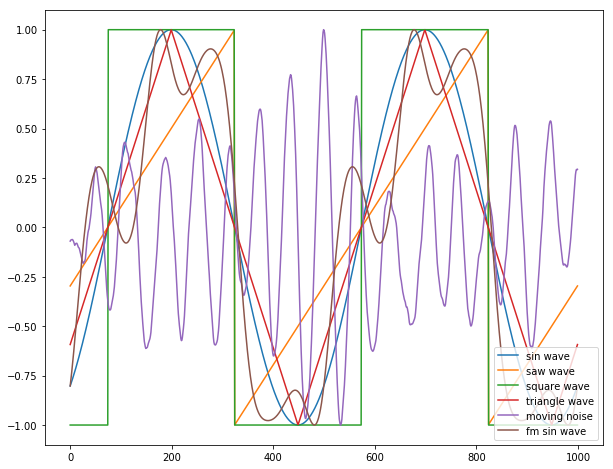

In [3]:
freq = 2
phase = np.pi*2 * np.random.rand()
sample = 1000
force = 0.1
damp = 0.01
cov = 0.01
fm_amp = 0.1
fm_freq = freq*3

plt.figure(figsize=(10,8))
plt.plot(sinwave(freq,phase,sample), label="sin wave")
plt.plot(sawwave(freq,phase,sample), label="saw wave")
plt.plot(sqwave(freq,phase,sample), label="square wave")
plt.plot(triwave(freq,phase,sample), label="triangle wave")
plt.plot(moving_noise(force,damp,cov,sample), label="moving noise")
plt.plot(fm_sinwave(freq,phase,fm_amp, fm_freq,sample), label="fm sin wave")
plt.legend(loc="lower right")
plt.show()


エコーする信号を予測するタスクでは$n_x = n_y = 1$かつ、$y_t = f(\{x_T\}_{T=0}^{t}) = x_{t-t_{\rm delay}}$である。$t_{\rm delay}$が正の場合、モデルが過去の記憶をどの程度保つかのテストとなり、$t_{\rm delay}$が負の場合、過去の系列から未来の信号を予測するタスクとなる。

In [4]:
def generate_echo_sequence(sequence, delay):
    sequence = np.roll(sequence,delay)
    
    # 存在しない信号については0で埋める。
    if delay > 0:
        sequence[:delay]=0
    elif delay<0:
        sequence[delay:]=0
    return sequence

下記のコードでエコーが生成出来ていることがわかる。

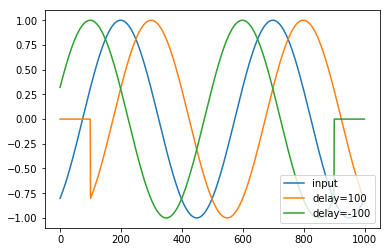

In [5]:
x = sinwave(freq,phase,sample)
y_p10 = generate_echo_sequence(x,100)
y_m10 = generate_echo_sequence(x,-100)
plt.plot(x,label="input")
plt.plot(y_p10,label="delay=100")
plt.plot(y_m10,label="delay=-100")
plt.legend(loc="lower right")
plt.show()

RNNのモデルでは時間$t$に依存する$n_h$次元の隠れ層$h_t \in \mathbb{R}^{n_h}$を考える。なお、$x_t, y_t, h_t$は全て横ベクトルとして扱う。初期状態の隠れ層$h_0$は0に初期化するか、正規分布などでランダムに決めておく。
$t\geq 1$についての$h_t$は行列$W_h, W_x$およびバイアスベクトル$b_h$を用いて
$$h_t = {\rm activate}_{\rm state}(h_{t-1} W_h  + x_{t-1} W_x  + b_h)$$ 
で漸化式として与えられる。ここで${\rm activate}_{\rm state}$は非線形性を確保し値の値域を$[-1,1]$に抑えるため、tanhやsigmoid関数を要素ごとに作用する操作がしばしば用いられる。以下のコードでは例としてtanhを例として紹介する。$W_h \in \mathbb{R}^{n_h \times n_h}$、$W_x \in \mathbb{R}^{n_x \times n_h}$、$b_h \in \mathbb{R}^{n_h}$はデータセットを説明するために最適化されるパラメータである。こうしたパラメータを訓練パラメータと呼ぶ。

時刻$t$での予測の出力$\tilde{y}_t$は$h_t$を用いて
$$\tilde{y}_t = {\rm activate}_{\rm out}(h_t W_y + b_y)$$
で与えられる。${\rm activate}_{\rm out}$も適当なelement-wiseな非線形関数である。$W_y \in \mathbb{R}^{n_h \times n_y}$と$b_y \in \mathbb{R}^{h_y}$は訓練パラメータである。
教師データとして時系列$\{x_t,y_t\}_{t=0}^T$を与えられたとき、学習の目的は$\tilde{y}_t$が$y_t$に近くなるよう$W_h, W_s, W_y$を訓練パラメータとして最適化することである。


上記の二つの式はベクトルを結合し一つの大きな行列をかけるという形に直すことができ、数値計算上はこちらの方が簡便である。具体的には、二つのベクトル$h_{t-1}, x_{t-1}$と定数1をつなげたベクトル$(h_{t-1}, x_{t-1}, 1)$と、行列$W \in \mathbb{R}^{(n_h+n_x+1) \times n_h}$を用いて以下のようにまとめることができる。
$$
h_t = {\rm activate}( (h_{t-1}, x_{t-1}, 1) W_{\rm state}) \\
\tilde{y}_t = {\rm activate}_{\rm out}( (h_{t-1}, 1) W_{\rm out})
$$
これを愚直に実装すると以下のようになる。

In [6]:
sequence_length = 1000
hidden_unit_count = 10
delay = 5
x = sinwave(freq,phase,sequence_length)
y = generate_echo_sequence(x,delay)

W_state = np.random.rand( hidden_unit_count+2, hidden_unit_count )
W_out = np.random.rand( hidden_unit_count+1, 1 )

state = np.zeros( hidden_unit_count )
y_pred = []
for sequence_cursor in range(sequence_length):
    new_state = np.tanh( np.concatenate( [state, [x[sequence_cursor],1] ] ) @ W_state )
    output = np.tanh( np.concatenate( [new_state, [1]]) @ W_out )
    output = np.squeeze(output,axis=0)
    y_pred.append(output)
    state = new_state

現状での信号を比較すると、でたらめな値を出していることがわかる。

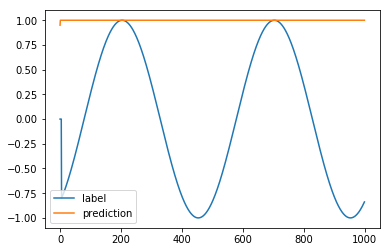

In [7]:
plt.plot(y,label="label")
plt.plot(y_pred,label="prediction")
plt.legend()
plt.show()

学習においては予測とラベルの差を測るロス関数を最小化する。ここではロス関数としてL2 distanceを採用する。従って訓練パラメータ$W_{\rm state}, W_{\rm out}$に依存する最小化するべき値$L$は
$$
L(W_{\rm state}, W_{\rm out}) = \sum_t \frac{\left| \tilde{y}_t - y_t \right|^2_{\rm L2}}{2}
$$
である。現状のロスは以下のように計算できる。

In [8]:
loss = np.sum( (y_pred - y)**2/2 )
print("loss=%f"%loss)

loss=745.046656


我々のタスクは、入出力のペアをいくつか教師データとして与えられた状態から初めて、未知のテストデータの入力に対し出力の予測を行うことである。

## 素朴なRNNによる時系列回帰

リカレントニューラルネットワークは時刻ごとのユニットレイヤがそれぞれ独立したレイヤだと思えば、深さがシーケンスの長さに等しいフィードフォワードニューラルネットワークだと考えることができる。このことを用いて、通常のニューラルネットワークで用いられるような逆誤差伝播と確率勾配法を用いて訓練パラメータの最適化を行うことができる。

以下ではtensorflowを用いたできるだけ素朴な実装を挙げる。注意点として、長いシーケンスをそのまま展開し逆誤差伝播を行うと、展開されたレイヤが深くなるためになかなか学習が進まない。このため、シーケンスを適切な長さのバッチに切ってこまめに逆後差伝播を行い同時にRNNとなっているレイヤの最終状態を保存しておき、次のバッチでは保存している状態を初期状態として学習を再開する。

このことを踏まえてtensorflowで素朴に(<code>BasicRNNCell</code>や<code>static_rnn</code>といった補助関数をできるだけ用いないで)RNNを実装すると以下のようになる。

In [9]:
class SimpleRecurrentNeuralNetwork(object):
    def __init__(self):
        self.session = None

    def __del__(self):
        if self.session is not None:
            self.session.close()

    def __feed_forward(self, input_sequence, initial_state):
        W_state = tf.Variable(tf.random_normal([self.hidden_unit_count+2, self.hidden_unit_count], dtype=tf.float64), dtype = tf.float64)
        W_out = tf.Variable(tf.random_normal([self.hidden_unit_count+1, 1], dtype=tf.float64), dtype=tf.float64)
        
        state = initial_state
        unstacked_input_sequence = tf.unstack(input_sequence, axis=1)
        unstacked_output_sequence = []
        for input_value in unstacked_input_sequence:
            input_value = tf.reshape(input_value, [-1, 1])
            bias_value = np.ones([self.sequence_count,1])
            concatenated_state = tf.concat([state, input_value, bias_value], axis=1)
            state = tf.tanh( tf.matmul(concatenated_state, W_state) )
            
            bias_value = np.ones([self.sequence_count,1])
            concatenated_state = tf.concat([state, bias_value], axis=1)
            output_value = tf.matmul(concatenated_state, W_out)
            unstacked_output_sequence.append(output_value)
        final_state = state
        output_sequence = tf.stack(unstacked_output_sequence, axis = 1)
        output_sequence = tf.squeeze(output_sequence,axis=2)
        return output_sequence, final_state

    def generate_batch(self, sequence_list, batch_length):
        sequence_count = sequence_list.shape[0]
        sequence_batch = np.reshape(sequence_list, [sequence_count, -1, batch_length] )
        sequence_batch = np.transpose(sequence_batch, [1,0,2])
        return sequence_batch

    def train(self, input_sequence_list, output_sequence_list, hidden_unit_count, batch_length = 10, learning_rate = 1e-5, epoch_count = 500):
        assert(input_sequence_list.shape == output_sequence_list.shape)
        if self.session is not None:
            self.session.close()
        tf.reset_default_graph()

        self.sequence_count, self.sequence_length = input_sequence_list.shape
        self.hidden_unit_count = hidden_unit_count
        self.batch_length = batch_length
        self.batch_count = self.sequence_length//self.batch_length

        self.input_sequence_op = tf.placeholder(tf.float64, [None, self.batch_length])
        self.output_sequence_op = tf.placeholder(tf.float64, [None, self.batch_length])
        self.initial_state_op = tf.placeholder(tf.float64, [None, self.hidden_unit_count])

        self.prediction_sequence_op, self.last_state_op = self.__feed_forward(self.input_sequence_op, self.initial_state_op)
        self.loss_op = tf.nn.l2_loss(self.prediction_sequence_op - self.output_sequence_op)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
        self.train_op = optimizer.minimize(self.loss_op/self.sequence_count)
        init_op = tf.global_variables_initializer()

        self.session = tf.Session()
        self.session.run(init_op)
        self.loss_history = []
        input_sequence_batch = self.generate_batch(input_sequence_list, self.batch_length)
        output_sequence_batch = self.generate_batch(output_sequence_list, self.batch_length)
        epoch_range = tqdm.trange(epoch_count)
        for _ in epoch_range:
            last_state = np.zeros( [self.sequence_count, self.hidden_unit_count] )
            loss_sum = 0
            for batch_index in range(self.batch_count):
                feed_dict = {
                    self.input_sequence_op: input_sequence_batch[batch_index],
                    self.output_sequence_op: output_sequence_batch[batch_index],
                    self.initial_state_op: last_state
                }
                _, loss, last_state = self.session.run([self.train_op, self.loss_op, self.last_state_op], feed_dict = feed_dict)
                loss_sum += loss/self.sequence_count
            self.loss_history.append(loss_sum)
            epoch_range.set_description("loss=%.3f"%loss_sum)

    def predict(self, input_sequence_list,output_sequence_list):
        sequence_count, sequence_length = input_sequence_list.shape
        input_sequence_batch = self.generate_batch(input_sequence_list, self.batch_length)
        output_sequence_batch = self.generate_batch(output_sequence_list, self.batch_length)
        batch_count = sequence_length //self.batch_length
        last_state = np.zeros( [sequence_count, self.hidden_unit_count] )
        prediction_sequence_batch_list = []
        loss_sum = 0
        for batch_index in range(batch_count):
            feed_dict = {
                self.input_sequence_op: input_sequence_batch[batch_index],
                self.output_sequence_op: output_sequence_batch[batch_index],
                self.initial_state_op: last_state
            }
            prediction_sequence_batch, last_state, loss = self.session.run([self.prediction_sequence_op, self.last_state_op, self.loss_op], feed_dict = feed_dict)
            prediction_sequence_batch_list.append(prediction_sequence_batch)
            loss_sum += loss/sequence_count
        prediction_sequence_list = np.hstack(prediction_sequence_batch_list)
        return prediction_sequence_list, loss_sum



このモデルを用いて先ほど定義した時系列を学習する。まずは教師データを生成しよう。

In [10]:
def generate_data(sequence_count, sequence_length, delay):
    input_sequence_list = []
    for sequence_index in range(sequence_count):
        r = sequence_index%6
        if r==0:
            input_sequence = sinwave(3.+np.random.rand()*3, np.random.rand()*2*np.pi, sequence_length)
        elif r==1:
            input_sequence = sqwave(3.+np.random.rand()*3, np.random.rand()*2*np.pi, sequence_length)
        elif r==2:
            input_sequence = triwave(3.+np.random.rand()*3, np.random.rand()*2*np.pi, sequence_length)
        elif r==3:
            input_sequence = sawwave(3.+np.random.rand()*3, np.random.rand()*2*np.pi, sequence_length)
        elif r==4:
            input_sequence = moving_noise(np.random.rand(), np.random.rand(), np.random.rand(), sequence_length)
        elif r==5:
            input_sequence = fm_sinwave(3.+np.random.rand()*3, np.random.rand()*2*np.pi, np.random.rand(), np.random.rand()*5, sequence_length)
        else:
            assert(0<=r and r<6)
            exit(0)
        input_sequence_list.append(input_sequence)

    output_sequence_list = []
    for input_sequence in input_sequence_list:
        output_sequence = generate_echo_sequence(input_sequence, delay)
        output_sequence_list.append(output_sequence)

    input_sequence_list = np.array(input_sequence_list)
    output_sequence_list = np.array(output_sequence_list)
    
    assert(input_sequence_list.shape == (sequence_count, sequence_length))
    assert(output_sequence_list.shape == (sequence_count, sequence_length))

    return input_sequence_list, output_sequence_list

In [11]:
sequence_count = 100
sequence_length = 400
delay = 5
input_sequence_list, output_sequence_list = \
    generate_data(sequence_count, sequence_length, delay)

次に、作成した教師データを用いて学習を行う。

In [12]:
model = SimpleRecurrentNeuralNetwork()
batch_length = 10
epoch_count = 300
learning_rate = 1e-3
hidden_unit_count = 10

model.train(input_sequence_list, output_sequence_list, hidden_unit_count, learning_rate = learning_rate, batch_length = batch_length, epoch_count = epoch_count)

loss=4.818: 100%|████████████████████████████████████████████████████████████████████| 300/300 [00:20<00:00, 16.61it/s]


学習結果の仮定でのロスのふるまいを表示すると以下のようになる。

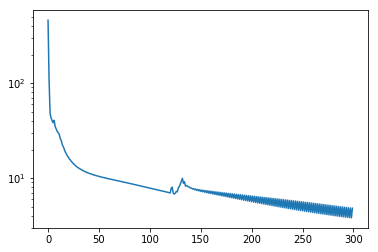

In [13]:
plt.plot(model.loss_history)
plt.yscale("log")
plt.show()

教師データに対する予測結果を見てみよう。

loss=3.689388


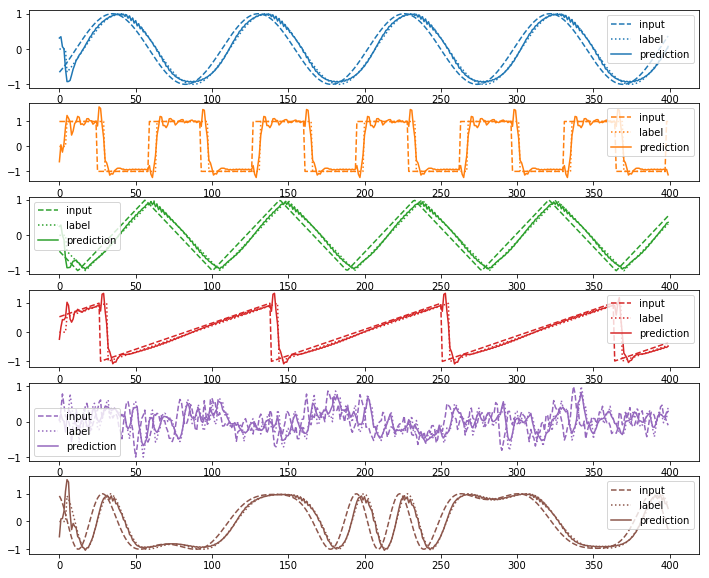

In [14]:
prediction_sequence_list, loss = model.predict(input_sequence_list,output_sequence_list)
print("loss=%f"%loss)
def plot(input_sequence_list, output_sequence_list, prediction_sequence_list):
    cmap = plt.get_cmap("tab10")
    plt.figure(figsize=(12,10))
    for index in range(6):
        plt.subplot(6,1,index+1)
        plt.plot(input_sequence_list[index],color=cmap(index),linestyle="--",label="input")
        plt.plot(output_sequence_list[index],color=cmap(index),linestyle=":",label="label")
        plt.plot(prediction_sequence_list[index],color=cmap(index),label="prediction")
        plt.legend()
    plt.show()
plot(input_sequence_list, output_sequence_list, prediction_sequence_list)

波形の種類によって学習の精度にばらつきはあるものの、データをそれなりにうまく説明できていることがわかる。なお、delayが小さい場合はほぼ入力と重なって見えることもあるが、計算するとその時刻での入力をそのまま出力する形になってしまった場合のロスより精度は高いことがわかる。

In [15]:
trained_loss = np.sum((prediction_sequence_list-output_sequence_list)**2)/2/sequence_count
trivial_loss = np.sum((input_sequence_list-output_sequence_list)**2)/2/sequence_count

print("trained loss=%f"%trained_loss)
print("trivial loss=%f"%trivial_loss)

trained loss=3.689388
trivial loss=43.343652


次に、学習したモデルが教師データに過学習していないことを示すため、テストデータを別途に作成しその振る舞いを調べる。

test_loss=3.808512


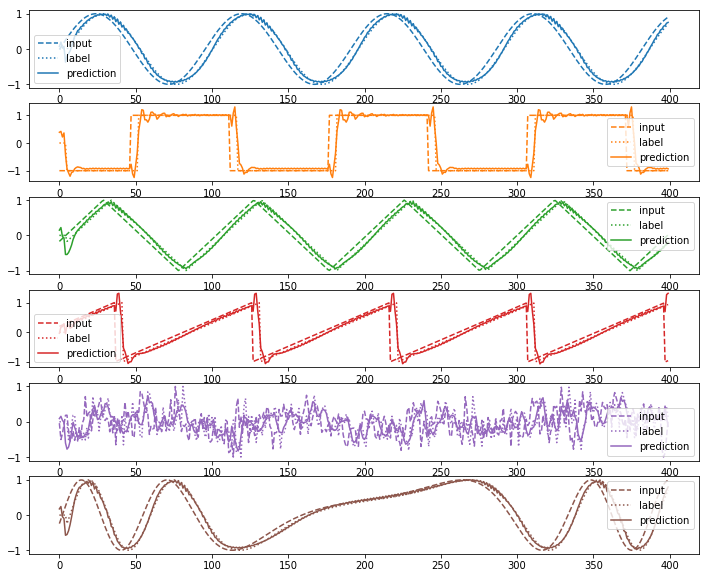

In [16]:
test_input_sequence_list, test_output_sequence_list = generate_data(sequence_count = sequence_count, sequence_length = sequence_length, delay = delay)
test_prediction_sequence_list, test_loss = model.predict(test_input_sequence_list,test_output_sequence_list)
print("test_loss=%f"%test_loss)
plot(test_input_sequence_list, test_output_sequence_list, test_prediction_sequence_list)

未知のデータに対しても教師データと同程度の予測結果が得られていることがわかる。（といっても位相の遅れや周波数しか変わらないが）

## より高度なRNN
リカレントするレイヤのセルをより複雑で表現能力の高いものに置き換えることで、より高い表現能力を獲得すると期待される。精度での学習を期待することができる。tensorflowはこうした代表的なRNNのセルを簡単に扱えるインターフェイスを提供している。下記はtensorflowのRNNCellを利用した場合のコードである。

In [17]:
class RecurrentNeuralNetwork_BasicCell(SimpleRecurrentNeuralNetwork):
    def __feed_forward(self, input_sequence):
        W_out = tf.Variable(tf.random_normal([self.hidden_unit_count+1, 1], dtype=tf.float64), dtype=tf.float64)
        input_sequence = tf.expand_dims(input_sequence, axis=2)
        unstacked_input_sequence = tf.unstack(input_sequence, axis=1)
        cell = tf.contrib.rnn.BasicRNNCell(self.hidden_unit_count)
        state_op = cell.zero_state(batch_size = self.sequence_count, dtype=tf.float64)
        unstacked_state, final_state = tf.contrib.rnn.static_rnn(cell, unstacked_input_sequence, dtype=tf.float64, initial_state = state_op)

        unstacked_output_sequence = []
        for state in unstacked_state:
            bias_value = np.ones([self.sequence_count,1])
            concatenated_state = tf.concat([state, bias_value], axis=1)
            output_value = tf.matmul(concatenated_state, W_out)
            unstacked_output_sequence.append(output_value)
        output_sequence = tf.stack(unstacked_output_sequence, axis = 1)
        output_sequence = tf.squeeze(output_sequence,axis=2)
        return output_sequence, final_state, state_op

    def train(self, input_sequence_list, output_sequence_list, hidden_unit_count, batch_length = 10, learning_rate = 1e-5, epoch_count = 500):
        assert(input_sequence_list.shape == output_sequence_list.shape)
        if self.session is not None:
            self.session.close()
        tf.reset_default_graph()

        self.sequence_count, self.sequence_length = input_sequence_list.shape
        self.hidden_unit_count = hidden_unit_count
        self.batch_length = batch_length
        self.batch_count = self.sequence_length//self.batch_length

        self.input_sequence_op = tf.placeholder(tf.float64, [None, self.batch_length])
        self.output_sequence_op = tf.placeholder(tf.float64, [None, self.batch_length])

        self.prediction_sequence_op, self.last_state_op, self.initial_state_op = self.__feed_forward(self.input_sequence_op)
        self.loss_op = tf.nn.l2_loss(self.prediction_sequence_op - self.output_sequence_op)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
        self.train_op = optimizer.minimize(self.loss_op/self.sequence_count)
        init_op = tf.global_variables_initializer()

        self.session = tf.Session()
        self.session.run(init_op)
        self.loss_history = []
        input_sequence_batch = self.generate_batch(input_sequence_list, self.batch_length)
        output_sequence_batch = self.generate_batch(output_sequence_list, self.batch_length)
        epoch_range = tqdm.trange(epoch_count)
        for _ in epoch_range:
            last_state = None
            loss_sum = 0
            for batch_index in range(self.batch_count):
                feed_dict = {
                    self.input_sequence_op: input_sequence_batch[batch_index],
                    self.output_sequence_op: output_sequence_batch[batch_index],
                }
                if batch_index > 0:
                    feed_dict[self.initial_state_op] = last_state
                _, loss, last_state = self.session.run([self.train_op, self.loss_op, self.last_state_op], feed_dict = feed_dict)
                loss_sum += loss/self.sequence_count
            epoch_range.set_description("loss=%.3f"%loss_sum)
            self.loss_history.append(loss_sum)

    def predict(self, input_sequence_list,output_sequence_list):
        sequence_count, sequence_length = input_sequence_list.shape
        input_sequence_batch = self.generate_batch(input_sequence_list, self.batch_length)
        output_sequence_batch = self.generate_batch(output_sequence_list, self.batch_length)
        batch_count = sequence_length //self.batch_length
        last_state = np.zeros( [sequence_count, self.hidden_unit_count] )
        prediction_sequence_batch_list = []
        loss_sum = 0
        for batch_index in range(batch_count):
            feed_dict = {
                self.input_sequence_op: input_sequence_batch[batch_index],
                self.output_sequence_op: output_sequence_batch[batch_index],
            }
            if batch_index > 0:
                feed_dict[self.initial_state_op] = last_state
            prediction_sequence_batch, last_state, loss = self.session.run([self.prediction_sequence_op, self.last_state_op, self.loss_op], feed_dict = feed_dict)
            prediction_sequence_batch_list.append(prediction_sequence_batch)
            loss_sum += loss/sequence_count
        prediction_sequence_list = np.hstack(prediction_sequence_batch_list)
        return prediction_sequence_list, loss_sum



早速学習を行ってみよう。

In [18]:
model = RecurrentNeuralNetwork_BasicCell()
model.train(input_sequence_list, output_sequence_list, hidden_unit_count, learning_rate = learning_rate, batch_length = batch_length, epoch_count = epoch_count)

loss=1.289: 100%|████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 17.38it/s]


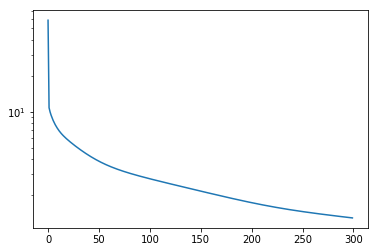

loss=1.281115


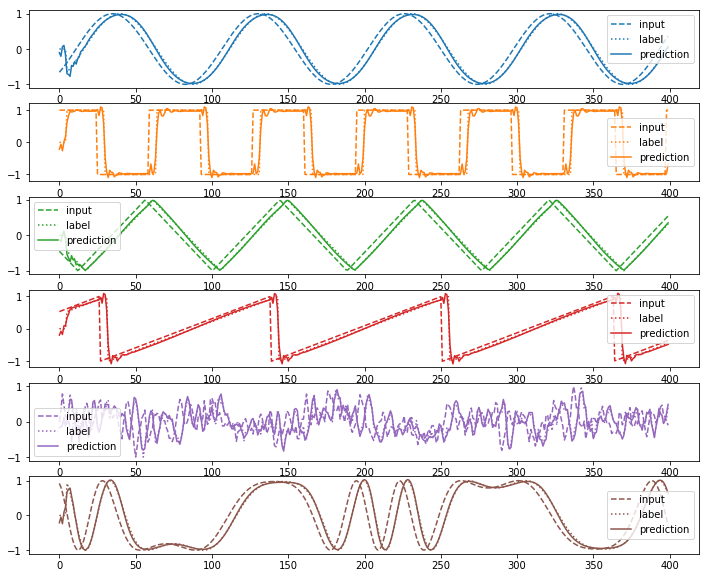

test_loss=1.300333


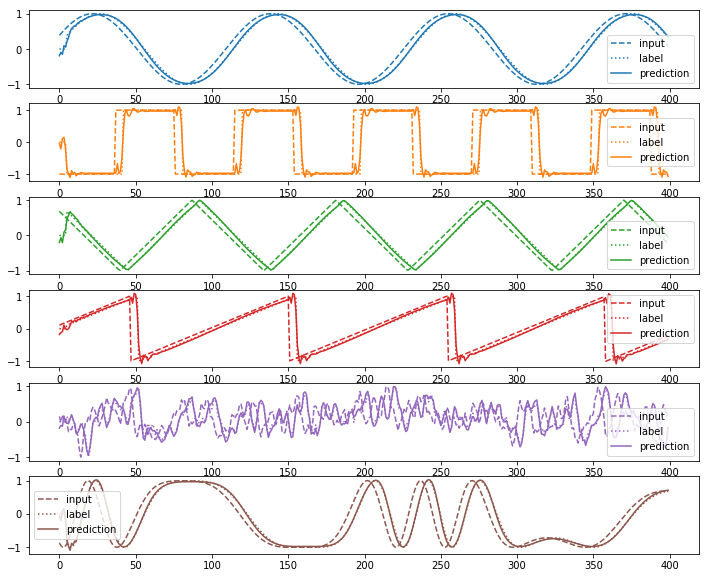

In [19]:
plt.plot(model.loss_history)
plt.yscale("log")
plt.show()

prediction_sequence_list, loss = model.predict(input_sequence_list,output_sequence_list)
print("loss=%f"%loss)
plot(input_sequence_list, output_sequence_list, prediction_sequence_list)

test_input_sequence_list, test_output_sequence_list = generate_data(sequence_count = sequence_count, sequence_length = sequence_length, delay = delay)
test_prediction_sequence_list, test_loss = model.predict(test_input_sequence_list,test_output_sequence_list)
print("test_loss=%f"%test_loss)
plot(test_input_sequence_list, test_output_sequence_list, test_prediction_sequence_list)

正しく学習できていることがわかる。上記モデルに少しの変更を加えることで、セルをLSTMに変更することができる。

In [20]:
import numpy as np
import tensorflow as tf

class RecurrentNeuralNetwork_LSTM(RecurrentNeuralNetwork_BasicCell):
    def __feed_forward(self, input_sequence):
        input_sequence = tf.expand_dims(input_sequence, axis=2)
        unstacked_input_sequence = tf.unstack(input_sequence, axis=1)
        cell = tf.contrib.rnn.BasicLSTMCell(self.hidden_unit_count, forget_bias = 1.0)
        state_op = cell.zero_state(batch_size = self.sequence_count, dtype=tf.float64)
        unstacked_state, final_state = tf.contrib.rnn.static_rnn(cell, unstacked_input_sequence, dtype=tf.float64, initial_state = state_op)

        unstacked_output_sequence = []
        for state in unstacked_state:
            output_value = tf.matmul(state,self.W_out) + self.b_out
            unstacked_output_sequence.append(output_value)
        output_sequence = tf.stack(unstacked_output_sequence, axis = 1)
        output_sequence = tf.squeeze(output_sequence,axis=2)
        return output_sequence, final_state, state_op

In [21]:
model = RecurrentNeuralNetwork_LSTM()
model.train(input_sequence_list, output_sequence_list, hidden_unit_count, learning_rate = learning_rate, batch_length = batch_length, epoch_count = epoch_count)

loss=0.818: 100%|████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 16.95it/s]


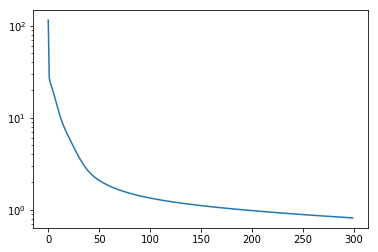

loss=0.814625


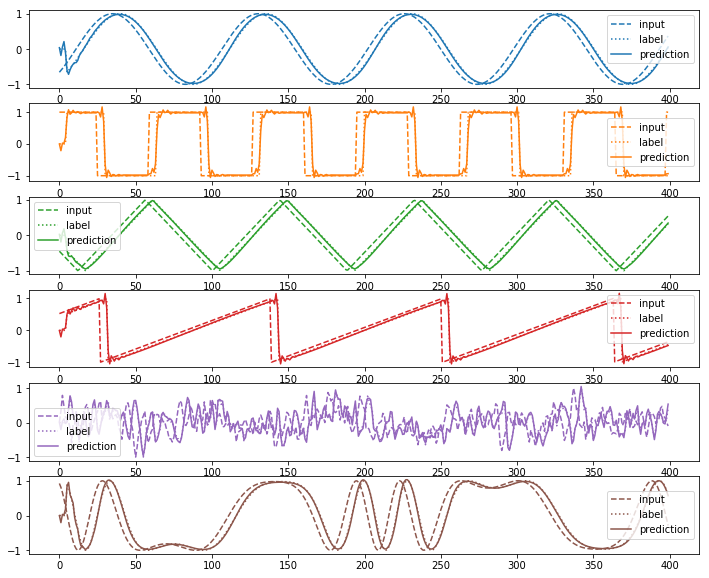

test_loss=0.810004


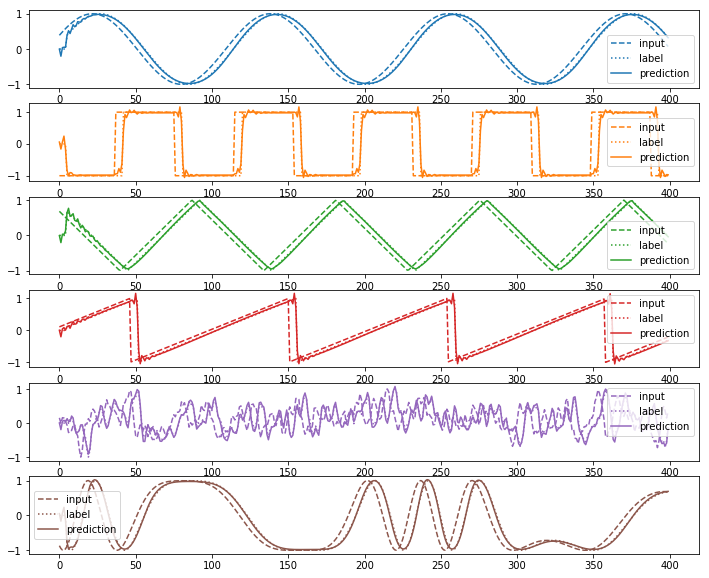

In [22]:
plt.plot(model.loss_history)
plt.yscale("log")
plt.show()

prediction_sequence_list, loss = model.predict(input_sequence_list,output_sequence_list)
print("loss=%f"%loss)
plot(input_sequence_list, output_sequence_list, prediction_sequence_list)

test_prediction_sequence_list, test_loss = model.predict(test_input_sequence_list,test_output_sequence_list)
print("test_loss=%f"%test_loss)
plot(test_input_sequence_list, test_output_sequence_list, test_prediction_sequence_list)

## リザーバコンピューティング
RNNでは時系列の予測を
$$
h_t = {\rm activate}( (h_{t-1}, x_{t-1}, 1) W_{\rm state}) \\
\tilde{y}_t = {\rm activate}_{\rm out}( (h_{t-1}, 1) W_{\rm out})
$$
と与えるものであった。

リザーバコンピューティングは予測に用いる関数の形式は上記の枠組みに入るものの、下記の点で異なる。

1. $W_{\rm state}$をランダムなパラメータで初期化し、学習を行わない。
2. ${\rm activate}_{\rm out}: x \rightarrow x$とする。

上記のような制約をRNNに加えることはモデルの自由度を狭める意味で不利である。一方、上記の制約のおかげでリザーバコンピューティングには下記のような利点がある。

1. 学習が$h_t$から$y_t$への線形回帰となるため、非常に高速に学習が行える。このため、$n_h$の値を大きくしても学習が十分高速に終了する。
2. $W_{\rm state}$の更新を行わないため、非線形だが相互作用の調整が難しいアナログなダイナミクスの時間発展を$h_t$の更新過程とみなすことができる。

学習が線形回帰となるため、逆誤差伝播や確率勾配法などを利用する必要がなくなる。具体的には、下記の手続きで計算を行う。

$$ \sum_t \left| y_t - W_y h_t + b_y \right|^2_{\rm L2}$$
を最小化するような$W_y$と$b_y$を求めたい。

この式は
$$
Y = \left( \begin{matrix} y_0^{\rm T} \\ \vdots \\ y_{T-1}^{\rm T} \end{matrix} \right)\\
H = \left( \begin{matrix} h_1^{\rm T} & 1 \\ \vdots & \vdots \\ h_T^{\rm T} & 1 \end{matrix} \right) \\
V = \left( \begin{matrix} W_y^{\rm T} \\ b_y^{\rm T} \end{matrix} \right)
$$
とおくことで、以下の式の最小化問題に置き換えられる。
$$
\left| Y - H V \right|^2_{\rm L2}
$$

これを最小化するのは$H$の疑似逆行列を$H^+$として$V = H^+ Y$である。疑似逆行列は$H$に対する特異値分解$H = U D V^{\dagger}$を考え、$D$の転置を取って非ゼロの対角要素を全て逆数にした行列を$D^+$としたとき、$H^+ := VD^+U^{\dagger}$となる。

技術的な注意点として、行列$H$が非常に小さい特異値を持っていた場合、逆数が発散し計算結果が不安定になってしまう。これを回避するために、あるしきい値を設けてその値より特異値が小さい場合は０とみなす処理が有効である。scipyのscipy.linalg.pinvではrcondという引数でこれがサポートされている。

In [23]:
class ReservoirComputing(object):
    def __feed_forward(self, input_sequence_list):
        sequence_count, sequence_length = input_sequence_list.shape
        predict_time_series = []
        state = np.zeros( [input_sequence_list.shape[0], self.hidden_unit_count] )
        state_list = []
        for sequence_index in range(sequence_length):
            
            input_value_list = input_sequence_list[:,sequence_index]
            input_value_list = np.expand_dims(input_value_list, axis=1)
            stacked_state = np.hstack( [state, input_value_list, np.ones([sequence_count,1])] )
            state = np.tanh( stacked_state @ self.W_state )
            state_list.append(state)

            stacked_state = np.hstack( [state, np.ones([sequence_count,1])])
            predict_value_list = stacked_state @ self.W_out
            predict_value_list = np.squeeze(predict_value_list, axis=1)
            predict_time_series.append(predict_value_list)
        predict_sequence_list = np.transpose(np.array(predict_time_series), [1,0])
        state_list = np.transpose(np.array(state_list),[1,0,2])
        return predict_sequence_list, state_list

    def train(self, input_sequence_list, output_sequence_list, hidden_unit_count, radius, beta):
        assert(input_sequence_list.shape == output_sequence_list.shape)
        self.hidden_unit_count = hidden_unit_count
        self.radius = radius

        self.sequence_count, self.sequence_length = input_sequence_list.shape
        self.hidden_unit_count = hidden_unit_count

        self.W_state = np.random.rand(self.hidden_unit_count+2, self.hidden_unit_count)
        self.W_out = np.random.rand(self.hidden_unit_count+1,1)

        norm = np.max(np.abs(np.linalg.eig(self.W_state[:self.hidden_unit_count,:])[0]))
        self.W_state *= self.radius/norm

        _, state_list = self.__feed_forward(input_sequence_list)
        state_list = np.array(state_list)
        V = np.reshape(state_list, [-1, hidden_unit_count])
        V = np.hstack( [V, np.ones([V.shape[0], 1]) ] )
        S = np.reshape(output_sequence_list, [-1])
        self.W_out = np.linalg.pinv(V, rcond = beta) @ S
        self.W_out = np.expand_dims(self.W_out,axis=1)

    def predict(self, input_sequence_list,output_sequence_list):
        prediction_sequence_list, _ = self.__feed_forward(input_sequence_list)
        loss = np.sum((prediction_sequence_list-output_sequence_list)**2)/2
        loss /= prediction_sequence_list.shape[0]
        return prediction_sequence_list, loss

早速学習を行ってみよう。

In [24]:
hidden_unit_count = 100
radius = 1.25
beta = 1e-14
model = ReservoirComputing()
start_time = time.time()
model.train(input_sequence_list, output_sequence_list, hidden_unit_count, radius, beta)
print("elapsed %f sec"%(time.time()-start_time))

elapsed 0.543546 sec


学習時間が圧倒的に高速であることがわかる。学習結果を見てみよう。

loss=6.179668


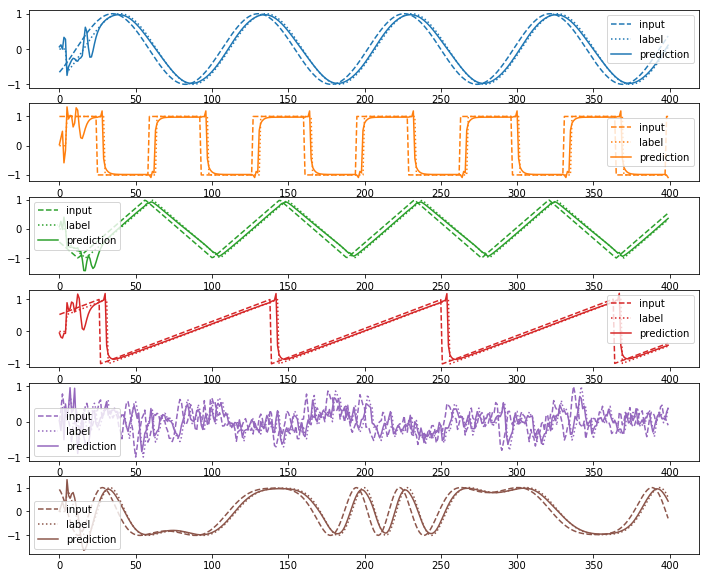

test_loss=6.474486


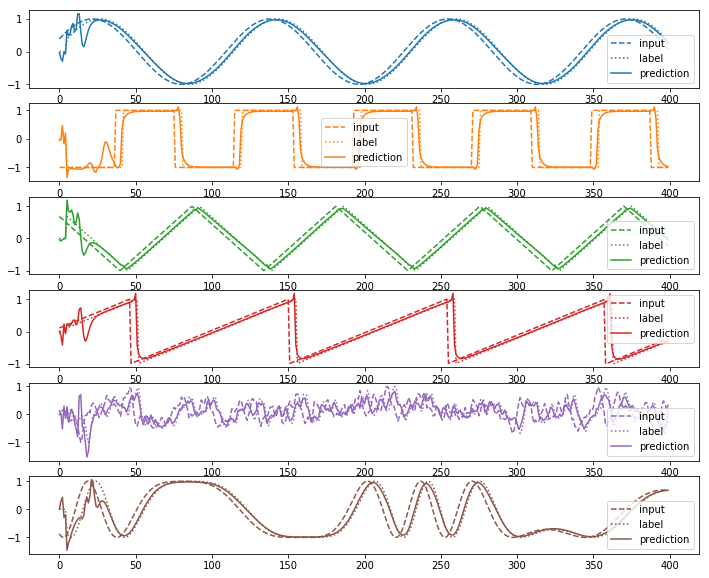

In [25]:
prediction_sequence_list, loss = model.predict(input_sequence_list,output_sequence_list)
print("loss=%f"%loss)
plot(input_sequence_list, output_sequence_list, prediction_sequence_list)

test_prediction_sequence_list, test_loss = model.predict(test_input_sequence_list,test_output_sequence_list)
print("test_loss=%f"%test_loss)
plot(test_input_sequence_list, test_output_sequence_list, test_prediction_sequence_list)

かなり良くフィットできているが、隠れ層のユニット数が10倍であるにも関わらずlossの値はRNNの結果に比べ劣っていることがわかる。これは学習が高速になったことの代償であるといういうことができる。

## 量子リザーバコンピューティング

量子リザーバコンピューティングとは、非線形性を有する物理系として量子系を用いたものである。
先述したようにリザーバコンピューティングはフィードフォワードなネットワークに比べアナログなシステムと相性が良いために、量子系もリザーバコンピューティングに自然に適用することができる。量子リザーバコンピューティングはごく最近提案された手法であり、いくつかの詳細で細かい改善の余地がある。下記の記述は論文[Boosting computational power through spatial multiplexing in quantum reservoir computing](https://arxiv.org/abs/1803.04574)を参考にした、あくまで一つの実装例であることに注意してほしい。

量子リザーバコンピューティングでは、隠れ層のユニット数を$n$としたとき、$n+1$個以上の量子ビットを用いてモデルを作成する。
入力の時系列は時間発展を行うハミルトニアンの個別の量子ビットに関する項の係数となる。
ニューロンの読み出しとしては、個々の量子ビットの期待値測定を用いる。
期待値を測定する必要があるため、量子ビットの間の相互作用の操作性が低くともコヒーレンス時間が長くアンサンブルとなっている物理系がこの実験に適している。
具体的には、並列して複数の量子系に同じユニタリ操作を行え、かつ容易にアンサンブルから期待値の測定が可能なNMRが量子リザーバコンピューティングに適していると目されている。

なお、シュレディンガー方程式は線形方程式であるため、上記システムは非線形ダイナミクスに当たらないように一見見えるかもしれないが、
量子力学が線形なのは波動関数に対してであって、時間発展後のパウリ基底での測定期待値は波動関数の要素に対して非線形になっているため、
入力がハミルトニアンの係数となり、出力が量子ビットの測定期待値とした場合、この対応は非線形なマップとなっている。

大規模な量子リザーバコンピューティングの動作は量子コンピュータが無ければ観測することが難しいものの、ユニット数が8個程度までの小規模なものであれば通常のラップトップでもシミュレートすることができる。

In [26]:
class QuantumReservoirComputing(object):
    def __feed_forward(self, input_sequence_list):
        sequence_count, sequence_length = input_sequence_list.shape
        predict_sequence_list = []
        state_list = []
        dim = 2**self.qubit_count
        sequence_range = tqdm.trange(sequence_count)
        for sequence_index in sequence_range:
            rho = np.zeros( [dim,dim] )
            rho[0,0]=1
            state = []
            for time_step in range(sequence_length):
                rho = self.P0op @ rho @ self.P0op + self.Xop[0] @ self.P1op @ rho @ self.P1op @ self.Xop[0]
                # (1 + u Z)/2 = (1+u)/2 |0><0| + (1-u)/2 |1><1|
                value = input_sequence_list[sequence_index, time_step]
                rho = (1+value)/2 * rho + (1-value)/2 *self.Xop[0] @ rho @ self.Xop[0]
                rho = self.Uop @ rho @ self.Uop.T.conj()

                current_state = []
                for qubit_index in range(1,self.qubit_count):
                    expectation_value = np.real(np.trace(self.Zop[qubit_index] @ rho))
                    current_state.append(expectation_value)
                state.append(current_state)
            state = np.array(state)
            state_list.append(state)

            stacked_state = np.hstack( [state, np.ones([sequence_length,1])])
            predict_sequence = stacked_state @ self.W_out
            predict_sequence = np.squeeze(predict_sequence, axis=1)
            predict_sequence_list.append(predict_sequence)
        predict_sequence_list = np.array(predict_sequence_list)
        state_list = np.array(state_list)
        return predict_sequence_list, state_list

    def train(self, input_sequence_list, output_sequence_list, hidden_unit_count, max_coupling_energy, trotter_step, beta):
        assert(input_sequence_list.shape == output_sequence_list.shape)
        self.hidden_unit_count = hidden_unit_count
        self.trotter_step = trotter_step

        self.sequence_count, self.sequence_length = input_sequence_list.shape
        self.hidden_unit_count = hidden_unit_count

        self.W_out = np.random.rand(self.hidden_unit_count+1,1)

        I = [[1,0],[0,1]]
        Z = [[1,0],[0,-1]]
        X = [[0,1],[1,0]]
        P0 = [[1,0],[0,0]]
        P1 = [[0,0],[0,1]]
        self.qubit_count = self.hidden_unit_count+1
        self.dim = 2**self.qubit_count
        self.Zop = [1]*self.qubit_count
        self.Xop = [1]*self.qubit_count
        self.P0op = [1]
        self.P1op = [1]

        for cursor_index in range(self.qubit_count):
            for qubit_index in range(self.qubit_count):
                if cursor_index == qubit_index:
                    self.Xop[qubit_index] = np.kron(self.Xop[qubit_index],X)
                    self.Zop[qubit_index] = np.kron(self.Zop[qubit_index],Z)
                else:
                    self.Xop[qubit_index] = np.kron(self.Xop[qubit_index],I)
                    self.Zop[qubit_index] = np.kron(self.Zop[qubit_index],I)

            if cursor_index == 0:
                self.P0op = np.kron(self.P0op, P0)
                self.P1op = np.kron(self.P1op, P1)
            else:
                self.P0op = np.kron(self.P0op, I)
                self.P1op = np.kron(self.P1op, I)

        self.hamiltonian = np.zeros( (self.dim,self.dim) )
        for qubit_index in range(self.qubit_count):
            coef = (np.random.rand()-0.5) * 2 * max_coupling_energy
            self.hamiltonian += coef * self.Zop[qubit_index]
        for qubit_index1 in range(self.qubit_count):
            for qubit_index2 in range(qubit_index1+1, self.qubit_count):
                coef = (np.random.rand()-0.5) * 2 * max_coupling_energy
                self.hamiltonian += coef * self.Xop[qubit_index1] @ self.Xop[qubit_index2]
        self.Uop = scipy.linalg.expm(1.j * self.hamiltonian)

        _, state_list = self.__feed_forward(input_sequence_list)

        state_list = np.array(state_list)
        V = np.reshape(state_list, [-1, hidden_unit_count])
        V = np.hstack( [V, np.ones([V.shape[0], 1]) ] )
        S = np.reshape(output_sequence_list, [-1])
        self.W_out = np.linalg.pinv(V, rcond = beta) @ S
        self.W_out = np.expand_dims(self.W_out,axis=1)

    def predict(self, input_sequence_list,output_sequence_list):
        prediction_sequence_list, _ = self.__feed_forward(input_sequence_list)
        loss = np.sum((prediction_sequence_list-output_sequence_list)**2)/2
        loss /= prediction_sequence_list.shape[0]
        return prediction_sequence_list, loss

早速計算を行ってみよう。

In [27]:
# この値は量子ビットに相当するため、大きくすると容易にOut of Memoryを起こすので注意
hidden_unit_count = 5
max_coupling_energy = 1.0
trotter_step = 10
beta = 1e-14
model = QuantumReservoirComputing()
model.train(input_sequence_list, output_sequence_list, hidden_unit_count, max_coupling_energy, trotter_step, beta)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.38it/s]


訓練の結果を見てみよう。古典のモデルと異なり、量子系をシミュレートするために予測についてもシミュレーションでは非常に時間がかかる。

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


loss=20.049381


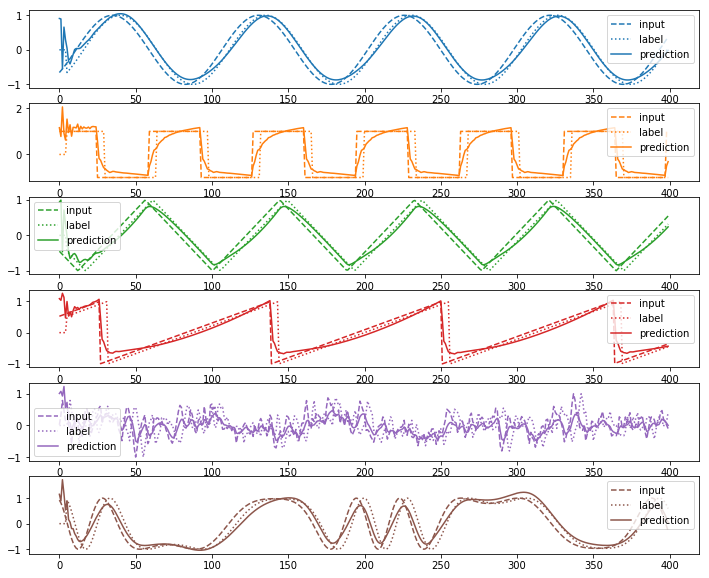

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  1.80it/s]


test_loss=19.180296


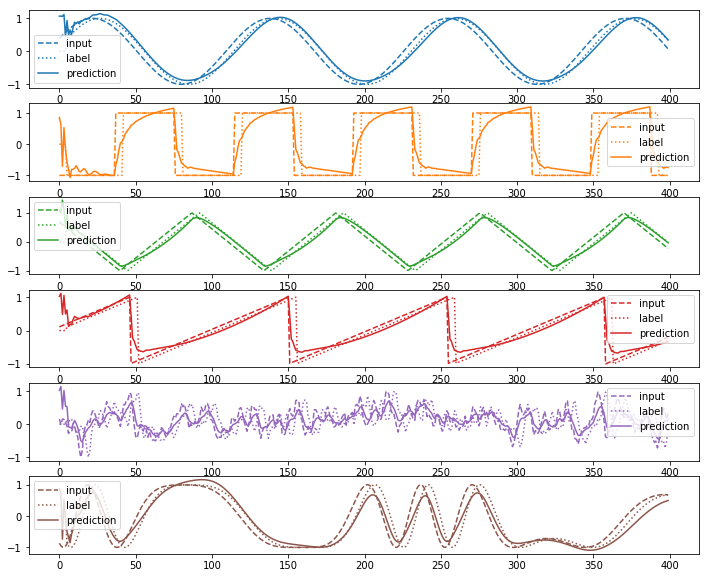

In [28]:
prediction_sequence_list, loss = model.predict(input_sequence_list,output_sequence_list)
print("loss=%f"%loss)
plot(input_sequence_list, output_sequence_list, prediction_sequence_list)

test_prediction_sequence_list, test_loss = model.predict(test_input_sequence_list,test_output_sequence_list)
print("test_loss=%f"%test_loss)
plot(test_input_sequence_list, test_output_sequence_list, test_prediction_sequence_list)

5量子ビットでもそこそこの精度がでていることがわかる。古典のRNNやリザバー計算の設定を変えてみて比較してみるとより理解が深まるだろう。

## 量子リザーバコンピューティングの性能について

リザーバコンピューティングを古典から量子に拡張するうえで最も気になる点は、量子リザーバコンピューティングは予測モデルとして古典リザーバコンピューティングよりも優れているか、という点である。二つの異なる学習モデルの性能を一つの軸で比較することは容易ではないが、いくつかの量子リザーバコンピューティングが古典よりも優れていると思われる点と、そうではない点がある。

量子リザーバコンピューティングが古典リザーバコンピューティングに対して持つ大きな利点は、量子リザーバコンピューティングは$n$qubitの量子状態が$2^n$次元のヒルベルト空間を自由に動ける点である。これは$n$個の実数値が動くことができる$n$次元の空間よりも広い。このことから、量子リザーバコンピューティングは同じビット数でも古典より高い表現能力を持つことが期待できる。これはいわゆるNISQでの量子機械学習が高い性能を持つと期待される理由と同じである。
なおNISQの代表格であるVQEなどの量子機械学習ではパラメータの最適化においてback propagationのような効率的な勾配計算が行えないという欠点があるが、量子リザーバコンピューティングは非線形系については最適化を一切行わないので、学習の低速さという欠点が自然に回避されている。

量子リザーバコンピューティングが古典リザーバコンピューティングに対して持つ欠点はクロックの速度と技術的なスケーラビリティである。現状の量子計算機はエラーを回避するためにクロックと系のスケールに制約がついてしまう。このため、非常に高次元な入力データを入力するリザーバコンピューティングを量子系で行うことは現状困難である。

また、古典リザーバコンピューティングは必ずしもアナログな系で実現する必要はなく、デジタル計算機上でシミュレートすることも可能である。デジタル計算機上で行われるリザーバーコンピューティングと比較すると、量子リザーバコンピューティングはノード間の相互作用としてハミルトニアンに従った時間発展しか許されないという欠点を持つ。デジタルな計算機上でリザーバコンピューティングをシミュレートする場合は二つのノード間のどのような相互作用も許されるので、好きな非線形関数をデザインすることができる。しかし、量子リザーバコンピューティングの枠組みでは量子力学で許された相互作用しか行うことができない。